In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.model_selection import RepeatedKFold
from sklearn.base import clone
from sklearn.model_selection import train_test_split

import keras
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import make_scorer
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)


In [31]:
path=r'/home/ludovico/ML-project/data/cup/ML-CUP23-'
train_set = pd.read_csv(path+'TR.csv',skiprows=7, header=None, delimiter=',', dtype=str)

input=train_set[train_set.columns[1:-3]]
target=train_set[train_set.columns[-3:]]


In [32]:
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=0, shuffle=True)

x=np.array(y_train[11].astype(np.float64))
y=np.array(y_train[12].astype(np.float64))
z=np.array(y_train[13].astype(np.float64))

x_train=x_train.astype(np.float32)
y_train=y_train.astype(np.float32)
x_test=x_test.astype(np.float32)
y_test=y_test.astype(np.float32)



In [33]:
def MEE(x, y):
    return np.mean(np.linalg.norm(x - y, 2, axis=1))


def create_model(init='uniform', activation='relu', nbr_features=10, dense_nparams=10,lr=0.1,momentum=0.1,w_d=0.0001, nest=False):
    model = Sequential()
    model.add(Dense(dense_nparams, activation, input_shape=(nbr_features,), kernel_initializer=init,)) 
    model.add(Dense(3, activation='linear', kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=SGD(lr,momentum,nest,w_d))
    return model

#callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)
keras_estimator = KerasRegressor(model=create_model,verbose=0)

In [38]:

initial_learning_rate = 0.02
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True)


param_grid = {
    'epochs': [1500],
    'model__dense_nparams': [100],
    'model__init': [ 'uniform' ], 
    'batch_size':[50],
    'model__lr':[lr_schedule],
    'model__momentum':[0.5],
    'model__w_d':[0.001],
    'model__activation':['tanh'],
    'model__nest':[False]
    
}

grid_search = GridSearchCV(
    estimator=keras_estimator,
    param_grid=param_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=1, random_state=0),
    n_jobs=-1,
    return_train_score = True,
    refit=True,
    scoring=make_scorer(MEE, greater_is_better=False),
    verbose=3,
    error_score='raise'
)

MLP=grid_search.fit(x_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


2024-01-09 12:14:53.845880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 12:14:53.846070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 12:14:53.847222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 12:14:53.853414: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 12:14:53.874807: E external/local_xla/xla/

[CV 4/5] END batch_size=50, epochs=1500, model__activation=tanh, model__dense_nparams=100, model__init=uniform, model__lr=<keras.src.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x7f17f5ebd090>, model__momentum=0.5, model__nest=False, model__w_d=0.001;, score=(train=-0.560, test=-0.800) total time=  34.4s
[CV 2/5] END batch_size=50, epochs=1500, model__activation=tanh, model__dense_nparams=100, model__init=uniform, model__lr=<keras.src.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x7f63047a5390>, model__momentum=0.5, model__nest=False, model__w_d=0.001;, score=(train=-0.556, test=-0.898) total time=  33.8s
[CV 1/5] END batch_size=50, epochs=1500, model__activation=tanh, model__dense_nparams=100, model__init=uniform, model__lr=<keras.src.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x7fc6f8c9d390>, model__momentum=0.5, model__nest=False, model__w_d=0.001;, score=(train=-0.560, test=-0.878) total time=  33.9s
[

In [39]:
cv_results_df = pd.DataFrame(MLP.cv_results_)
best_model_index=MLP.best_index_

print('best params',MLP.best_params_) 

val_loss=cv_results_df['mean_test_score'][best_model_index]
val_std=cv_results_df['std_test_score'][best_model_index]
train_loss=cv_results_df['mean_train_score'][best_model_index]
train_std=cv_results_df['std_train_score'][best_model_index]
print('Train loss:',train_loss,'+/-', train_std)
print('Validation loss:',val_loss,'+/-', val_std)

cv_results_df

best params {'batch_size': 50, 'epochs': 1500, 'model__activation': 'tanh', 'model__dense_nparams': 100, 'model__init': 'uniform', 'model__lr': <keras.src.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x7f88c059fe80>, 'model__momentum': 0.5, 'model__nest': False, 'model__w_d': 0.001}
Train loss: -0.5589210867881775 +/- 0.00165889971341677
Validation loss: -0.8285709023475647 +/- 0.05293242623849712


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_model__activation,param_model__dense_nparams,param_model__init,param_model__lr,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,36.924993,3.701822,0.102784,0.021967,50,1500,tanh,100,uniform,<keras.src.optimizers.schedules.learning_rate_...,...,-0.828571,0.052932,1,-0.559875,-0.555835,-0.560206,-0.560156,-0.558533,-0.558921,0.001659


Epoch 1/3000
4/4 [==============================] - 0s 43ms/step - loss: 750.3738 - val_loss: 533.0443
Epoch 2/3000
4/4 [==============================] - 0s 11ms/step - loss: 378.7646 - val_loss: 91.6704
Epoch 3/3000
4/4 [==============================] - 0s 10ms/step - loss: 60.4388 - val_loss: 40.6369
Epoch 4/3000
4/4 [==============================] - 0s 9ms/step - loss: 34.8693 - val_loss: 29.5132
Epoch 5/3000
4/4 [==============================] - 0s 10ms/step - loss: 25.7805 - val_loss: 21.9734
Epoch 6/3000
4/4 [==============================] - 0s 9ms/step - loss: 19.9701 - val_loss: 17.0522
Epoch 7/3000
4/4 [==============================] - 0s 9ms/step - loss: 16.6571 - val_loss: 19.7985
Epoch 8/3000
4/4 [==============================] - 0s 10ms/step - loss: 24.7739 - val_loss: 15.3601
Epoch 9/3000
4/4 [==============================] - 0s 9ms/step - loss: 13.9124 - val_loss: 9.2549
Epoch 10/3000
4/4 [==============================] - 0s 9ms/step - loss: 10.3694 - val_loss: 

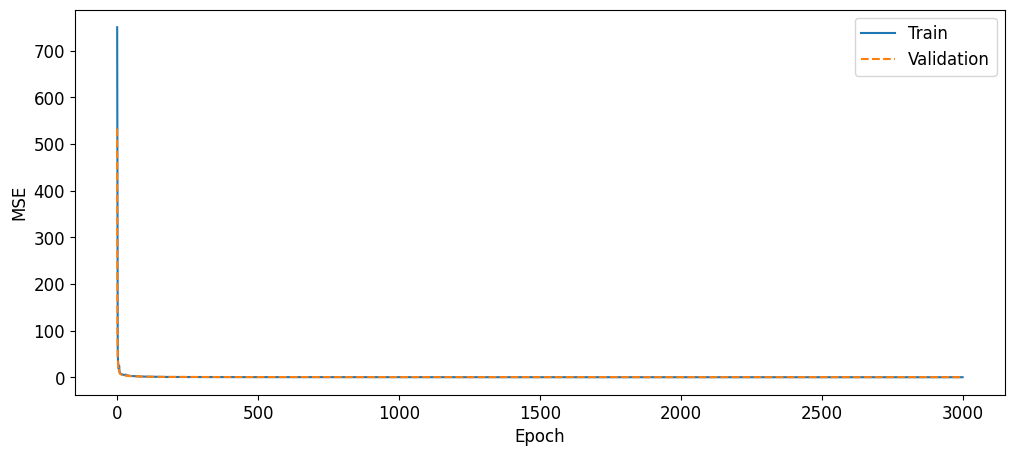

In [27]:
# Fit the model
x_train_cl, x_val, y_train_cl, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)

model=KerasRegressor(model=create_model,**grid_search.best_params_)
history = model.fit(x_train_cl, y_train_cl.astype(np.float32),validation_data=(x_val,y_val.astype(np.float32)))

# list all data in history

plt.rcParams.update({'font.size': 12})

print(history.history_.keys())
# summarize history for accuracy
plt.figure(figsize=(12,5))
# summarize history for loss
plt.plot(history.history_['loss'])
plt.plot(history.history_['val_loss'], linestyle='--')

plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

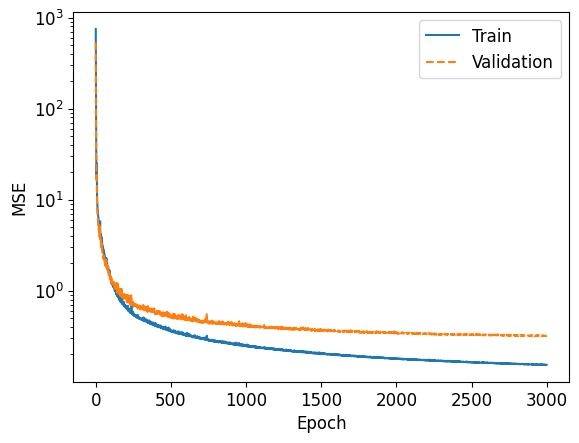

In [28]:
# summarize history for loss
plt.plot(history.history_['loss'])
plt.plot(history.history_['val_loss'], linestyle='--')

plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.yscale('log')
#plt.xlim(0,1000)
#plt.ylim(0,10)
plt.legend(['Train', 'Validation'], loc='best')
plt.show()